In [0]:
!pip install tensorflow-gpu==1.14
!pip install bayesian-optimization
!pip install -q tensorflow-hub
!pip install -q seaborn

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import our dependencies
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer
import numpy as np
from pathlib import Path
import codecs
import csv
from sklearn.model_selection import train_test_split
from tqdm import trange
from bayes_opt import BayesianOptimization
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.backend import set_session

# Initialize session
sess = tf.Session()
graph = tf.get_default_graph()

global sess
global graph

print(tf.__version__)

Using TensorFlow backend.


1.14.0


In [0]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [0]:
env_url = Path('/content/drive/My Drive/TP-final-SI')

embedding_dim = 300
max_lenght = 70
trunc_type = 'post'
oov_tok = '<00V>'

In [0]:
file_url = env_url/'dataSetUserStoriesRecognition-tunend1.csv'

######LOADING FILE
csvfile = codecs.open(file_url, 'r', encoding='utf-8', errors='ignore')
reader = csv.DictReader(csvfile, delimiter=';')

data = []
labels = []

for row in reader:
  data.append(row['Resumen'].lower())
  labels.append(int(row['Class'].lower()))

#print(len(data))
#print(len(labels))
csvfile.close()

In [0]:
del csvfile
del reader

In [0]:
#####SPLIT TRAINING-VALIDATION
data_train, data_test, labels_train, labels_test = train_test_split(
    data, labels, test_size = 0.3,
    train_size = 0.7, shuffle = 1, random_state=42,  stratify=labels
)

In [0]:
# Create a custom layer that allows us to update weights (lambda layers do not have trainable parameters!)

class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

In [0]:
def initialize_vars(sess):
  with graph.as_default():
      sess.run(tf.local_variables_initializer())
      sess.run(tf.global_variables_initializer())
      sess.run(tf.tables_initializer())
      set_session(sess)

In [0]:
def build_model(dropout_rate = 0.1):
  input_text = layers.Input(shape=(1,), dtype="string")
  embedding = ElmoEmbeddingLayer()(input_text)
  dense = layers.Dropout(rate=dropout_rate)(embedding)
  pred = layers.Dense(1, activation='sigmoid')(dense)

  model = Model(inputs=[input_text], outputs=pred)

  #model.summary()
 
  model.compile(loss='binary_crossentropy', optimizer="SGD", metrics=['accuracy'])

  initialize_vars(sess)
  return model

In [0]:
def build_and_train_model(dropout_rate = 0.1,
                batch_s = 25, verbose = 0, save_model = False, epchs = 20, opti = True):  

  
  model = build_model(dropout_rate)
  history = model.fit(np.array(data_train), np.array(labels_train), epochs=epchs,
                      batch_size = int(batch_s), validation_data=(np.array(data_test), np.array(labels_test)), verbose = verbose)
  if save_model:
    model.save(format(env_url/'rnn-elmo-usrecog.h5'), "w+")  

  if opti:
      return history.history["val_acc"][-1]
  else:  
      return model,history;

In [0]:
def load_model():
  # Clear and load model
  model = None
  model = build_model()
  model.load_weights(format(env_url/'rnn-elmo-usrecog.h5'))
  return model

In [0]:
def optimization():
    hypScope = {
        'dropout_rate': (0.1,0.4),
        'batch_s': (32,64)
    }
    bo = BayesianOptimization(build_and_train_model, hypScope)
    bo.maximize()
    print(bo.max)

In [0]:
optimization()

|   iter    |  target   |  batch_s  | dropou... |
-------------------------------------------------
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


|  1        |  0.9621   |  54.73    |  0.1707   |
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


|  2        |  0.9633   |  58.39    |  0.2318   |
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


|  3        |  0.9591   |  42.71    |  0.2621   |
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


|  4        |  0.9575   |  55.56    |  0.3582   |
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


|  5        |  0.9583   |  52.76    |  0.3001   |
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


|  6        |  0.9612   |  32.0     |  0.1      |
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


|  7        |  0.9587   |  64.0     |  0.1024   |
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


|  8        |  0.9646   |  32.01    |  0.2022   |
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


|  9        |  0.9667   |  32.0     |  0.1101   |
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


|  10       |  0.97     |  35.98    |  0.1001   |
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


|  11       |  0.9637   |  36.36    |  0.1007   |
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


|  12       |  0.9654   |  35.57    |  0.1003   |
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


ResourceExhaustedError: ignored

In [0]:
model, history = build_and_train_model(batch_s=36, dropout_rate= 0.1, verbose=1, epchs = 20, save_model = True, opti = False)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 5597 samples, validate on 2399 samples
Epoch 1/20
5597/5597 [==============================] - 101s 18ms/step - loss: 0.4437 - acc: 0.7922 - val_loss: 0.3702 - val_acc: 0.8624
Epoch 2/20
5597/5597 [==============================] - 90s 16ms/step - loss: 0.3390 - acc: 0.8774 - val_loss: 0.2944 - val_acc: 0.9037
Epoch 3/20
5597/5597 [==============================] - 90s 16ms/step - loss: 0.2709 - acc: 0.9080 - val_loss: 0.2438 - val_acc: 0.9287
Epoch 4/20
5597/5597 [==============================] - 90s 16ms/step - loss: 0.2301 - acc: 0.9253 - val_loss: 0.2113 - val_acc: 0.9266
Epoch 5/20
5597/5597 [==============================] - 90s 16ms/step - loss: 0.2031 - acc: 0.9292 - val_loss: 0.1834 - val_acc: 0.9375
Epoch 6/20
5597/5597 [==============================] - 90s 16ms/step - loss: 0.1833 - acc: 0.9423 - val_loss: 0.1651 - val_acc: 0.9458
Epoch 7/20
5597/5597 [==============================] - 90s 16ms/step - loss: 0.1727 - acc: 0.9414 - val_loss: 0.1515 - val_acc: 0.9504

In [0]:
import matplotlib.pyplot as plt

def plot_graphics(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show

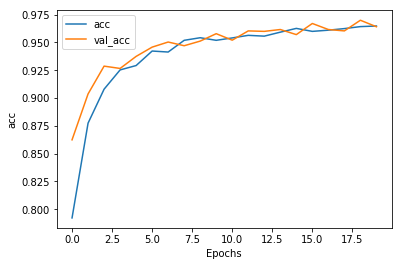

In [0]:
plot_graphics(history, 'acc')

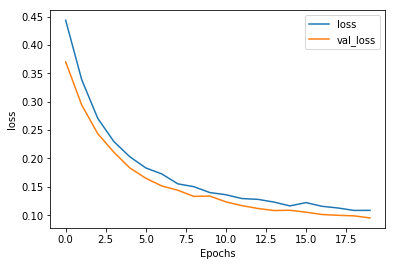

In [0]:
plot_graphics(history, 'loss')

In [0]:
if (env_url/'rnn-elmo-usrecog.h5').exists():
  model = load_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def isUserStory(text):        
    #PREDICT PART OF CLASS
    predicted = model.predict(text, verbose = 0)   
    return predicted

In [0]:
"""csvfile_in = codecs.open(format(env_url/"new_tunned_examples-1.csv"), 'r', encoding='utf-8', errors='ignore')
reader = csv.DictReader(csvfile_in, delimiter=';')

csvfile_out = open(format(env_url/'new_tunned_examples_classified.csv'),"w+")
fieldnames = ['Resumen','Class']
writer = csv.DictWriter(csvfile_out, fieldnames=fieldnames)

writer.writeheader()
track = []
i = 0
for row in reader:   
  #print(row)
  resumen = row["Resumen"]
  if resumen != "":
    prob_pred =  isUserStory(np.array([resumen]))
    if prob_pred[0][0] > 0.95:
      track.append(i)
      writer.writerow({'Resumen': resumen, 'Class': 1})
    else:  
      writer.writerow({'Resumen': resumen, 'Class': 0})
  i = i + 1

csvfile_in.close()
csvfile_out.close()

print(len(reader.values()))
print(len(track))
print(format(track))
print("Results saved successfuly")"""  

'csvfile_in = codecs.open(format(env_url/"new_tunned_examples-1.csv"), \'r\', encoding=\'utf-8\', errors=\'ignore\')\nreader = csv.DictReader(csvfile_in, delimiter=\';\')\n\ncsvfile_out = open(format(env_url/\'new_tunned_examples_classified.csv\'),"w+")\nfieldnames = [\'Resumen\',\'Class\']\nwriter = csv.DictWriter(csvfile_out, fieldnames=fieldnames)\n\nwriter.writeheader()\ntrack = []\ni = 0\nfor row in reader:   \n  #print(row)\n  resumen = row["Resumen"]\n  if resumen != "":\n    prob_pred =  isUserStory(np.array([resumen]))\n    if prob_pred[0][0] > 0.95:\n      track.append(i)\n      writer.writerow({\'Resumen\': resumen, \'Class\': 1})\n    else:  \n      writer.writerow({\'Resumen\': resumen, \'Class\': 0})\n  i = i + 1\n\ncsvfile_in.close()\ncsvfile_out.close()\n\nprint(len(reader.values()))\nprint(len(track))\nprint(format(track))\nprint("Results saved successfuly")'

In [0]:
 
test_examples =  [
  "As a developer, I want to implement tests",
  "As a cat, i want",
  "As a cat, i want to be fed",
  "As a dog, i want to be washed",
  "As a tester, I want to implement tests so i can assure the softwares quality",
  "As a cat, I want to implement tests so i can assure the softwares quality",
  "as an administrator i want a gui admin for configuration options",
  "As a CONNECT administrator or security officer, I want to view audit events via the System Admninistration module so that I can monitor the audit logs and events",
  "A tester want to implement tests so he can assure the software quality",
  "An administrator will audit event via the system administration module",
  "An admnistrtor will audit event via the system administration module",
  "As a bug, I want reports so it can be check",
  "As a system, I want to be able in the all time",
  "An developer build should take less than 5 minutes",
  "As a developer the default build should take less than 5 minuts",
  "As a IA tester, I want to wrtie with ortografics errors to test efficiency",
  "I want a developer as much as good tester so I have a good team"
]

print("#####Text to analize -> [probability of being an userstory]#####") 
for ex in test_examples:
  prob_pred =  isUserStory(np.array([ex]))  
  print(ex + "->" + format(prob_pred))

#####Text to analize -> [probability of being an userstory]#####
As a developer, I want to implement tests->[[0.8398521]]
As a cat, i want->[[0.16595891]]
As a cat, i want to be fed->[[0.23020056]]
As a dog, i want to be washed->[[0.28962797]]
As a tester, I want to implement tests so i can assure the softwares quality->[[0.56291276]]
As a cat, I want to implement tests so i can assure the softwares quality->[[0.4027194]]
as an administrator i want a gui admin for configuration options->[[0.99803513]]
As a CONNECT administrator or security officer, I want to view audit events via the System Admninistration module so that I can monitor the audit logs and events->[[0.21359973]]
A tester want to implement tests so he can assure the software quality->[[0.00051016]]
An administrator will audit event via the system administration module->[[0.00036453]]
An admnistrtor will audit event via the system administration module->[[0.00064726]]
As a bug, I want reports so it can be check->[[0.0475456